This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data). The synthesis model is a logistic/multinomial logistic regression.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [3]:
# import standardized lat/long location data
train_data = pd.read_csv("Data/cleaned_ipums_data.csv")

***

In [4]:
train_data

,INCWAGE,years_of_educ,potential_experience,non_white,SEX
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


***

Testing logistic and multinomial logistic regression synthesizers.

In [5]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [6]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [7]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_non_white_,
                    C_sex_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["INCWAGE", "years_of_educ", "potential_experience"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ["INCWAGE", "years_of_educ", "potential_experience"]
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non-white MN ##########
    
    synth_non_white_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["INCWAGE", "years_of_educ", "potential_experience"]], 
                                                   synth_data_sets=sXs, 
                                                   target=train_data.non_white, 
                                                   penalty_param=C_non_white_)
    
    sXs = [pd.concat([Y, synth_non_white_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["INCWAGE", "years_of_educ", "potential_experience", "non_white"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.SEX, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [8]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_non_white_, C_sex_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_non_white_=C_non_white_,
                                            C_sex_=C_sex_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_non_white_": (0.001, 2),
            "C_sex_": (0.001, 2)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [9]:
nsd = 20
ngi = 5
# random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
random_states = [np.random.RandomState(1234)]

In [10]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | C_non_... |  C_sex_   | num_co... |
-------------------------------------------------------------
| 1         | -0.02939  | 0.3838    | 1.245     | 93.6      |
| 2         | -2.568    | 1.571     | 1.56      | 62.06     |
| 3         | -0.05942  | 0.5537    | 1.604     | 193.0     |
| 4         | -0.000290 | 1.752     | 0.7163    | 105.7     |
| 5         | -0.1867   | 1.367     | 1.426     | 80.71     |
| 6         | -0.1698   | 2.0       | 1.234     | 179.4     |
| 7         | -13.99    | 0.001     | 2.0       | 121.2     |
| 8         | -0.6009   | 1.238     | 1.462     | 106.7     |
| 9         | -9.398e-0 | 2.0       | 2.0       | 100.6     |
| 10        | -159.1    | 0.001     | 0.001     | 164.7     |
| 11        | -0.009129 | 1.839     | 1.843     | 185.0     |
| 12        | -3.358e+0 | 0.001     | 0.001     | 43.79     |
| 13        | -1.061    | 1.988     | 1.869     | 68.75     |
| 14        | -0.02998  | 2.0       | 2.0       | 140.7     |
| 15    

In [13]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

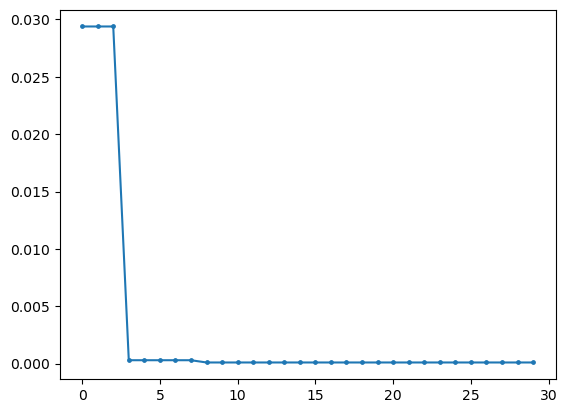

In [14]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
# plt.plot(run_targets[1])
# plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
# plt.plot(run_targets[2])
# plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
# plt.plot(run_targets[3])
# plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
# plt.plot(run_targets[4])
# plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
# plt.title("Running Minimum Objective Value for MNL Synthesis")
# plt.ylim(-0.01, 0.47)
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [15]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [16]:
best_params

{'target': -9.397582018007855e-05,
 'params': {'C_non_white_': 2.0,
  'C_sex_': 2.0,
  'num_components_': 100.60057522746453}}

Generate 20 synthetic data sets.

In [21]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=nsd,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_non_white_=best_params['params']['C_non_white_'],
                                             C_sex_=best_params['params']['C_sex_'])

In [23]:
np.mean(pmse_ratios)

1.0526487574176793

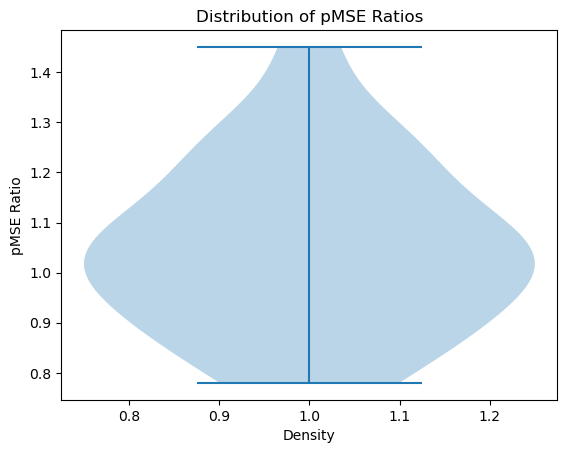

In [24]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [26]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/logistic_optimizer_logistic_pmse_ipums_" + str(i) + ".csv", index=False)

***